# In this notebook we would like to implement the Variational Gradient Origin Network.

### The paper link : https://arxiv.org/pdf/2007.02798v5.pdf

### Variational GON published code : https://github.com/cwkx/GON/blob/master/Variational-GON.py

### Some important sentences from the paper

=> (Abstract): "This paper proposes a new type of generative model that is able to quickly learn a latent representation without an encoder" 

=> (Abstract): "This is achieved using empirical Bayes to calculate the expectation of the posterior, which is implemented by initializing a latent vector with zeros, then using the gradient of the log-likelihood of the data with respect to this zero vector as new latent points."

=> (Introduction): "This paper proposed Gradient Origin Networks (GONs), a new type of generative model that do not require encoders or hypernetworks. This is achieved by initialising latent points at the origin, then using the gradient of the log-likelihood of the data with respect to these points as the latent space." 

=> (3.3 Variational GONs) : "A feedforward neural network F parametrises $p(x|z)$, while the expectation of $p(z|x)$ is calculated with emprical Bayes. A normal prior is assumed over $p(z)$ thus

$\hat{z}(z_0) = z_0 + \nabla_{z_0} (log p(x|z_0) + log \mathcal{N}(z_0; 0 , 2I_d))$

where $z_0 = 0$ as discussed in Section 3.1 (Gradient Origin Networks). While it would be possible to use this estimate directly within a constant-variance VAE, we opt to incorporate the reparametrization trick into the generative network as a stochastic layer, to represent the distribution over which $x$ could be encoded to, using empirical Bayes to estimate $z$. 
...
The forward pass of $F$ is implemented as follows: $\hat{z}_x$ (or$z_0$) is mapped by linear transformations to $\mu(\hat{z}_x)$ and $\sigma(\hat{z}_x)$ and the reparametrization trick is applied, providing parameters for $p(x|\hat{z}_x)$. Training is performed end-to-end, minimizing the ELBO."

# Import Required Libraries

In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
# using Interpolations
Atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

params (generic function with 2 methods)

# Define some Ploting Utility Functions

In [3]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, plot_size = (900,300))
#     k = rand(1:10, n_instances)
    k = [i for i = 1:10]
    ori_plot_list = reshape(im_ori[:,:,:,k[1]], (32, 32))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (32, 32))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,:,:,j], (32, 32)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,:,:,j], (32, 32)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = plot_size)
end

function plot_weight_histograms(theta)
    L = length(theta)
    for i = 1:L
        s = size(theta[i])
        display(histogram([flatten(Array{Float32}(value(theta[i])))...],title = "Size of Weight : $s", xlabel = "Values", ylabel = "count", label = "w", grid = true,nbins=100))
    end
end

plot_weight_histograms (generic function with 1 method)

# Image Tensor Resizing Function 
### GON Uses 32 x 32 Images whereas MNIST is 28 x 28
### Therefore, we apply Linear Spline Interpolation to the Dataset

In [4]:
function resize_gray_image_tensor(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

function resize_MNIST(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img'), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

resize_MNIST (generic function with 3 methods)

# Read MNIST Dataset

In [5]:
xtrn,_ = MNIST.traindata()
xtst,_ = MNIST.testdata()
xtrn = Array{Float64, 3}(xtrn)
xtst = Array{Float64, 3}(xtst)

xtrn = resize_MNIST(xtrn, 32/28)
xtst = resize_MNIST(xtst, 32/28)

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = Atype)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = Atype);

# Visualize Some Images

,,,,,,,,,

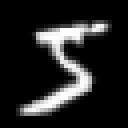
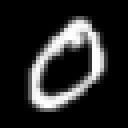
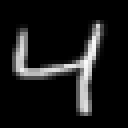
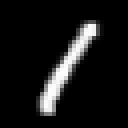
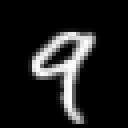
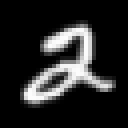
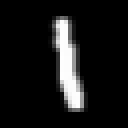
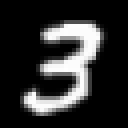
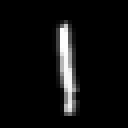
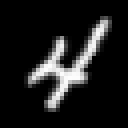

In [6]:
k = 1:10
[Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]

# We use Pytorch Default Weight Initializations. For reference, check the following links

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [7]:
function deconv_weight_init(w1::Int, w2::Int, cx::Int, cy::Int; bias::Bool = true, return_param = false)
    k = sqrt(1/(cy * w1 * w2))
    if return_param
        if bias
            return param(rand(Uniform(-k,k), w1, w2, cy, cx)), param(rand(Uniform(-k,k), 1, 1, cy, 1))
        else
            return  param(rand(Uniform(-k,k), w1, w2, cy, cx))
        end
    else
        if bias
            return (rand(Uniform(-k,k), w1, w2, cy, cx)), (rand(Uniform(-k,k), 1, 1, cy, 1))
        else
            return  (rand(Uniform(-k,k), w1, w2, cy, cx))
        end
    end
end

function conv_weight_init(w1::Int, w2::Int, cx::Int, cy::Int; bias::Bool = true, return_param = false)
    k = sqrt(1/(cx * w1 * w2))
    if return_param
        if bias
            return param(rand(Uniform(-k, k), w1, w2, cx, cy)), param(rand(Uniform(-k, k), 1, 1, cx, 1))
        else
            return param(rand(Uniform(-k, k), w1, w2, cx, cy))
        end
    else
        if bias
            return (rand(Uniform(-k, k), w1, w2, cx, cy)), (rand(Uniform(-k, k), 1, 1, cx, 1))
        else
            return (rand(Uniform(-k, k), w1, w2, cx, cy))
        end
    end
end

function linlayer_weight_init(i::Int, o::Int; bias::Bool = true, return_param = false)
    k = sqrt(1/i)
    if return_param
        if bias
            return param(rand(Uniform(-k, k), o, i)), param(rand(Uniform(-k, k), o, 1))
        else
            return param(rand(Uniform(-k, k), o, i))
    end
    else
        if bias
            return (rand(Uniform(-k, k), o, i)), (rand(Uniform(-k, k), o, 1))
        else
            return (rand(Uniform(-k, k), o, i))
        end
    end
end


linlayer_weight_init (generic function with 1 method)

# Initialize Model Weights as param Datatype

In [8]:
function weights(nz, ngf)
    
    # Decoding Weights
    theta = [] # z -> x

    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    
    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    push!(theta, param(bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    push!(theta, param(bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    push!(theta, param(bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, 1;bias = true, return_param = true)
    push!(theta, w)
    push!(theta, b)
    
#     theta = map(a->convert(Atype,a), theta)
    
    return theta
end

weights (generic function with 1 method)

# Define Reparametrization and Decoding (Model) Function

In [9]:
function reparametrize(mu, logvar)
    
    std = exp.(0.5 .* logvar)
    epsilon = convert(Atype, randn(F, size(mu)))
    z = mu .+ epsilon .* std
    
    return z
end

function decode(theta, z; batch_size = 64, training = true)
    
    mu = theta[1] * z .+ theta[2]
    logvar = theta[3] * z .+ theta[4]
    
    z = reparametrize(mu, logvar)
    
    z = reshape(z, (1, 1, nz, batch_size))
    z = deconv4(theta[5], z, mode = 1) .+ theta[6]
    z = batchnorm(z, bnmoments(), theta[7]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[8], z, stride = 2, padding = 1, mode = 1) .+ theta[9]
    z = batchnorm(z, bnmoments(), theta[10]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[11], z, stride = 2, padding = 1, mode = 1) .+ theta[12]
    z = batchnorm(z, bnmoments(), theta[13]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[14], z, stride = 2, padding = 1, mode = 1) .+ theta[15]
    x_hat = Knet.sigm.(z)
    
    return x_hat, mu, logvar
    
end

decode (generic function with 1 method)

# Test Forward Pass of The Model
### We use Origin as the latent vector for this test

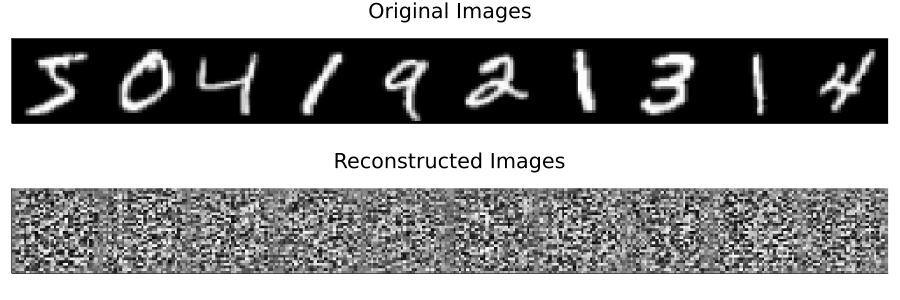

In [10]:
nz = 48
ngf = 32
nc = 1
x = first(dtrn)

theta = weights(nz, ngf);

origin = param(Atype(zeros(nz, batch_size)))

x_hat, mu, logvar = decode(theta, origin);

plot_reconstructed_images(x, x_hat, 10, (900,300))

# Define Loss Functions

In [11]:
function BCE(x_tensor,x_hat_tensor)
    x = mat(x_tensor)
    x_hat = mat(x_hat_tensor)
    return -mean(sum((x .* log.(x_hat .+ F(1e-10)) + (1 .- x) .* log.(1 .- x_hat .+ F(1e-10))), dims = 1))
end

function KLD(mu, logvar)
    var = exp.(logvar)
    std = sqrt.(var)
    KL = -0.5 * mean(sum(1 .+ logvar .- (mu .* mu) - exp.(logvar), dims = 1))
    return KL
end

function loss(theta, x, z)
    x_hat, mu, logvar = decode(theta, z)
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
end

loss (generic function with 1 method)

# Test Loss Function and Its Derivative

In [12]:
nz = 48
ngf = 32
nc = 1
x = first(dtrn)

theta = weights(nz, ngf);

origin = param(Atype(zeros(nz, batch_size)))

println("The printed loss and the value of derivative origin might be slightly different due to the reparametrization function (randomness)")

println("Loss : ", loss(theta, x, origin))
derivative_origin = @diff loss(theta, x, origin)

The printed loss and the value of derivative origin might be slightly different due to the reparametrization function (randomness)
Loss : 785.4194839596748


T(785.5934341549873)

# Overall, the network is supposed to used as the in the following code.
# However, this implementation has a problem which is mentioned after the following code cell.

In [13]:
# Initialize latent and output dims as well as number of channels
nz = 48
ngf = 32
nc = 1
# Define learning rate
lr = 1e-4
# Take the first batch of the data
x = first(dtrn)

# Initialize the weights
theta = weights(nz, ngf);

# Initialize an origin network as the first latent vector. Use param datatype to take the gradient of loss w.r.t. origin
origin = param(Atype(zeros(nz, batch_size)))

# Take derivative of the loss function w.r.t. origin vector
derivative_origin = @diff loss(theta, x, origin)

# Initialize the latent vector to the minus gradient of the loss function (w.r.t. origin)
dz = grad(derivative_origin, origin)
z = (-dz)

# Use the minus gradient as the latent vector and feed it to the decoding network
derivative_model = @diff loss(theta, x, z)

# Update the model with an Adam optimizer using the gradients of the model w.r.t. weights.
for p in theta
    dp = grad(derivative_model, p)
    update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
end

# The published Pytorch code for the Variational GON is the following (here I gave some part of it, please check the given link for the whole code)

x = x.to(device)

### \# compute the gradients of the inner loss with respect to zeros (gradient origin)

z = torch.zeros(batch_size, nz).to(device).requires_grad_()

g, mu, logvar = F(z)

inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)

grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=True)[0]

z = (-grad)

### \#now with z as our new latent points, optimise the data fitting loss
g, mu, logvar = F(z)

outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)

optim.zero_grad()

outer_loss.backward()

optim.step()


### \# In this code, retain_graph = True parameter is used while taking the gradient of the loss w.r.t. origin. Therefore, after computing the latent point, the gradient of the loss w.r.t. model weights in the second step is affected by this first step (taking gradient of the loss w.r.t. origin).Hence, my Julia implementation above corresponds to the following Pytorch code;
x = x.to(device)

z = torch.zeros(batch_size, nz).to(device).requires_grad_()

g, mu, logvar = F(z)

inner_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)

### \#The following 2 lines of code changed (retain_graph = False,  and detaching of the gradient)
grad = torch.autograd.grad(inner_loss, [z], create_graph=True, retain_graph=False)[0]

z = (-grad).detach()


g, mu, logvar = F(z)

outer_loss, BCE, KLD = vae_loss(g, x, mu, logvar, 1.0)

optim.zero_grad()

outer_loss.backward()

optim.step()

# Mainly, my problem is to track the gradient of the loss w.r.t. origin while updating the model weights. Therefore, the gradients of the loss w.r.t. model weights must be affected by the gradient of the loss function w.r.t. the origin latent vector. In order to solve this problem, I tried to write the following function, which includes the gradient of the loss w.r.t. origin inside the function. With this way, I tried to write a new (conceptually same loss function) loss function which uses the following decoding function.

In [14]:
function decode_train(theta, x; batch_size = 64,training = true)
    origin = param(Atype(zeros(nz, batch_size)))

    derivative_origin = @diff loss(value.(theta), x, origin)
    dz = grad(derivative_origin, origin)

    z = -value(dz)

    x_hat, mu, logvar = decode(theta, origin);
    return x_hat, mu, logvar
end

decode_train (generic function with 1 method)

In [15]:
decode_train(theta, x)

(K32(32,32,1,64)[0.5053746⋯], K32(48,64)[0.024040466⋯], K32(48,64)[0.13412856⋯])

# Then, my idea is to use the gradient of the following loss w.r.t. the model weights to optimize the GON model. Therefore, we define the following loss function

In [16]:
function loss_train(theta, x)
    x_hat, mu, logvar = decode_train(theta, x)
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
end

loss_train (generic function with 1 method)

In [17]:
loss_train(theta, x)

953.9360806047916

# Loss function works fine. If we are able to take the gradient of this loss function w.r.t. the model weights, then I believe we can train the GON. However, I have the following "Stacktrace" error while taking the derivative of the "loss_train" function.

In [18]:
@diff loss_train(theta, x)


Stacktrace:
  [1] copyto!(a::KnetArray{Float32, 4}, b::Base.Broadcast.Broadcasted{Base.Broadcast.Style{AutoGrad.Value}, NTuple{4, Base.OneTo{Int64}}, typeof(identity), Tuple{AutoGrad.Result{KnetArray{Float32, 4}}}})
    @ Knet.KnetArrays ~/.julia/packages/Knet/RCkV0/src/knetarrays/broadcast.jl:35
  [2] copyto!(x::AutoGrad.Result{KnetArray{Float32, 4}}, y::Base.Broadcast.Broadcasted{Base.Broadcast.Style{AutoGrad.Value}, NTuple{4, Base.OneTo{Int64}}, typeof(identity), Tuple{AutoGrad.Result{KnetArray{Float32, 4}}}})
    @ AutoGrad ~/.julia/packages/AutoGrad/TTpeo/src/core.jl:55
  [3] materialize!
    @ ./broadcast.jl:894 [inlined]
  [4] materialize!
    @ ./broadcast.jl:891 [inlined]
  [5] materialize!(dest::AutoGrad.Result{KnetArray{Float32, 4}}, x::AutoGrad.Result{KnetArray{Float32, 4}})
    @ Base.Broadcast ./broadcast.jl:887
  [6] batchnorm4_back(g::KnetArray{Float32, 4}, x::AutoGrad.Result{KnetArray{Float32, 4}}, dy::AutoGrad.Result{KnetArray{Float32, 4}}; eps::Float64, training::Bo

LoadError: MethodError: no method matching copyto!(::KnetArray{Float32, 4}, ::AutoGrad.Result{KnetArray{Float32, 4}})
[0mClosest candidates are:
[0m  copyto!(::KnetArray{T, N} where N, [91m::Array{T, N} where N[39m) where T at /kuacc/users/bbozkurt15/.julia/packages/Knet/RCkV0/src/knetarrays/copy.jl:10
[0m  copyto!(::KnetArray{T, N} where N, [91m::Array{S, N} where N[39m) where {T, S} at /kuacc/users/bbozkurt15/.julia/packages/Knet/RCkV0/src/knetarrays/copy.jl:18
[0m  copyto!(::KnetArray{T, N} where N, [91m::KnetArray{T, N} where N[39m) where T at /kuacc/users/bbozkurt15/.julia/packages/Knet/RCkV0/src/knetarrays/copy.jl:9
[0m  ...